# <center> Paper Experimental Results </center>

We provide in this notebook a set of routines to generate and reproduce the plots observed in the original paper. 

In [1]:
# Libraries 
import os
import torch
import argparse
import torchvision
import numpy as np
from glob import glob
import torch.utils.data
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

#Set reproducibility seeed
torch.manual_seed(1)

## VLB Evaluation
The point of this experiment is to evaluate the Variational Lower Bound (VLB) for our Variational Sparse Coding (VSC) model given different sparcity values  $\alpha$, also for a Variational Autoencoder (VAE) for varying number of latent dimension. 

The following commands were executed in order to obtain the trained models needed for our future plots. 

### Mnist 

- ** python vae-mnist.py --epochs 11 --latent x **
- ** python vsc-mnist.py --epochs 11 --latent x --alpha 0.5**
- ** python vsc-mnist.py --epochs 11 --latent x --alpha 0.2**
- ** python vsc-mnist.py --epochs 11 --latent x --alpha 0.01**


### Fashion Mnist 

- ** python vae-mnist.py --epochs 11 --latent x --fashion **
- ** python vsc-mnist.py --epochs 11 --latent x --alpha 0.5 --fashion **
- ** python vsc-mnist.py --epochs 11 --latent x --alpha 0.2 --fashion **
- ** python vsc-mnist.py --epochs 11 --latent x --alpha 0.01**


for all values of **x** which start from $8$ until $200$ with steps of $8$. 


### Observations:

- We trained the model for a total of **11** epochs over the whole training set (**60000** 28x28 images) using a batch size of **32** for **11** epochs. In other words, which is equivalent to a total number of $\frac{60K \times 11}{32} = 20625$. It worths noting that in the original paper however, the authors considered a limit of **20000** iterations (total number of batches) using a batch size of **32**.

### Define Models

In [2]:
# VAE model 
class VAE(nn.Module):
    def __init__(self, latent ):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent)
        self.fc22 = nn.Linear(400, latent)
        self.fc3 = nn.Linear(latent, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #Recognition function
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        #Likelihood function
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
# VSC Model 
class VSC(nn.Module):
    def __init__(self, latent):
        super(VSC, self).__init__()
        self.c = 200.0 
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent )
        self.fc22 = nn.Linear(400, latent)
        self.fc23 = nn.Linear(400, latent)
        self.fc3 = nn.Linear(latent, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #Recognition function
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1), -F.relu(-self.fc23(h1))

    def reparameterize(self, mu, logvar, logspike ):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        gaussian = eps.mul(std).add_(mu)
        eta = torch.rand_like(std)
        selection = F.sigmoid(self.c*(eta + logspike.exp() - 1))
        return selection.mul(gaussian)

    def decode(self, z):
        #Likelihood function
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar, logspike = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar, logspike)
        return self.decode(z), mu, logvar, logspike
    

### Auxiliary functions

In [3]:
# Loss functions
def loss_vae(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average = False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def loss_vsc(alpha):
    
    def loss_vsc_(x, recon_x,  mu, logvar, logspike):
        
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average = False)
        spyke = torch.clamp( logspike.exp() , 1e-6 , 1.0 - 1e-6 )
        PRIOR = -0.5 * torch.sum( spyke.mul(1 + logvar - mu.pow(2) - logvar.exp()))  + \
                torch.sum( (1-spyke).mul(torch.log((1-spyke)/(1 - alpha))) + \
                spyke.mul(torch.log(spyke/alpha) ) )
        return BCE + PRIOR
        
    return loss_vsc_

### Load pre-trained models

In [3]:
## VAE - MNIST
vae_mnist_models = []
for i in range(8,201,8):
    vae_mnist_models.append(VAE(i))
    vae_mnist_models[-1].load_state_dict(torch.load('../src/models/vae_mnist_1_11_' + str(i) +'_0-001_11_.pth'))
    
## VSC - MNIST - alpha 0.5
vsc_mnist_models_05 = []
for i in range(8,201,8):
    vsc_mnist_models_05.append( VSC(i))
    vsc_mnist_models_05[-1].load_state_dict(torch.load('../src/models/vsc_mnist_1_11_' + str(i) + '_0-001_0.5_11_.pth'))
    
## VSC - MNIST - alpha 0.2
vsc_mnist_models_02 = []
for i in range(8,201,8):
    vsc_mnist_models_02.append( VSC(i))
    vsc_mnist_models_02[-1].load_state_dict(torch.load('../src/models/vsc_mnist_1_11_' + str(i) + '_0-001_0.2_11_.pth'))
    
## VAE - FASHION
vae_fashion_models = []
for i in range(8,201,8):
    vae_fashion_models.append(VAE(i))
    vae_fashion_models[-1].load_state_dict(torch.load('../src/models/vae_fashion_1_11_' + str(i) +'_0-001_11_.pth'))
    
## VSC - FASHION - alpha 0.5
vsc_fashion_models_05 = []
for i in range(8,201,8):
    vsc_fashion_models_05.append( VSC(i))
    vsc_fashion_models_05[-1].load_state_dict(torch.load('../src/models/vsc_fashion_1_11_' + str(i) + '_0-001_0.5_11_.pth'))
    
## VSC - FASHION - alpha 0.2
vsc_fashion_models_02 = []
for i in range(8,201,8):
    vsc_fashion_models_02.append( VSC(i))
    vsc_fashion_models_02[-1].load_state_dict(torch.load('../src/models/vsc_fashion_1_11_' + str(i) + '_0-001_0.2_11_.pth'))

###  Load data 

In [4]:
# Load test data
BATCH_SIZE = 32

## MNIST
mnist_test_loader = torch.utils.data.DataLoader(
                        datasets.MNIST('../data/mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)

## FASHION
fashion_test_loader = torch.utils.data.DataLoader(
                        datasets.FashionMNIST('../data/fashion-mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)

### VLB Report

In [5]:
# VLB reporting
def vlb(model, test_loader, loss_function ):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            kwargs = model(data)
            test_loss += loss_function(data , *kwargs ).item()
    return test_loss / (i+1)

In [5]:
### Evaluate VLB  for each model  ( it may take a couple of minutes )

## MNIST - VAE
mnist_vae_vlb = []
for model in vae_mnist_models:
    mnist_vae_vlb.append ( vlb(model, mnist_test_loader, loss_vae ) )

## MNIST - VSC - alpha = 0.5
mnist_vsc_vlb_05 = []
for model in vsc_mnist_models_05:
    mnist_vsc_vlb_05.append ( vlb(model, mnist_test_loader, loss_vsc(0.5) ) )
    
## MNIST - VSC - alpha = 0.2
mnist_vsc_vlb_02 = []
for model in vsc_mnist_models_02:
    mnist_vsc_vlb_02.append ( vlb(model, mnist_test_loader, loss_vsc(0.2) ) )
    
## FASHION - VAE
fashion_vae_vlb = []
for model in vae_fashion_models:
    fashion_vae_vlb.append ( vlb(model, fashion_test_loader, loss_vae ) )

## FASHION - VSC - alpha = 0.5
fashion_vsc_vlb_05 = []
for model in vsc_fashion_models_05:
    fashion_vsc_vlb_05.append ( vlb(model, fashion_test_loader, loss_vsc(0.5) ) )
    
## FASHION - VSC - alpha = 0.2
fashion_vsc_vlb_02 = []
for model in vsc_fashion_models_02:
    fashion_vsc_vlb_02.append ( vlb(model, fashion_test_loader, loss_vsc(0.2) ) )


In [6]:
# Store resulsts
np.save( '../src/results/mnist-vae-vlb', np.asarray(mnist_vae_vlb) )
np.save( '../src/results/mnist-vsc-vlb-05', np.asarray(mnist_vsc_vlb_05) )
np.save( '../src/results/mnist-vsc-vlb-02', np.asarray(mnist_vsc_vlb_02) )

np.save( '../src/results/fashion-vae-vlb', np.asarray(fashion_vae_vlb) )
np.save( '../src/results/fashion-vsc-vlb-05', np.asarray(fashion_vsc_vlb_05) )
np.save( '../src/results/mnist-vsc-vlb-02', np.asarray(fashion_vsc_vlb_02) )

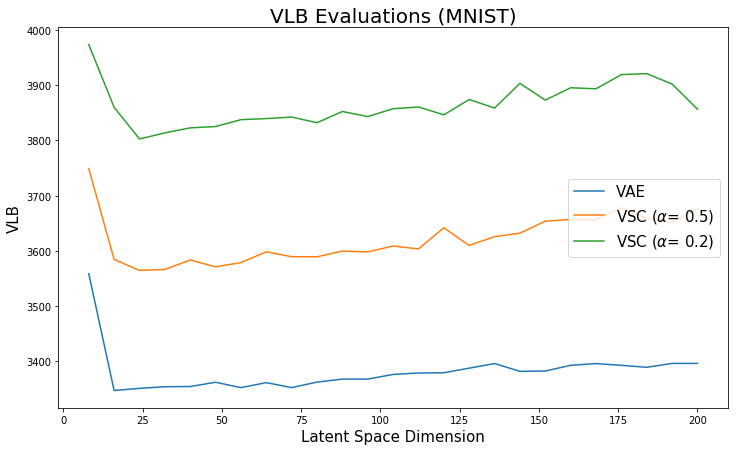

In [8]:
# Plot VLB evaluations
x = np.arange(8,201,8)
plt.figure(figsize = (12, 7))
plt.title('VLB Evaluations (MNIST)', fontsize = 20 )
plt.plot( x , mnist_vae_vlb, label = 'VAE' )
plt.plot( x , mnist_vsc_vlb_05, label = r'VSC ($\alpha$= 0.5)' )
plt.plot( x , mnist_vsc_vlb_02, label = r'VSC ($\alpha$= 0.2)' )
plt.ylabel('VLB', fontsize = 15)
plt.xlabel('Latent Space Dimension', fontsize = 15)
plt.legend(loc='right', fontsize = 15)

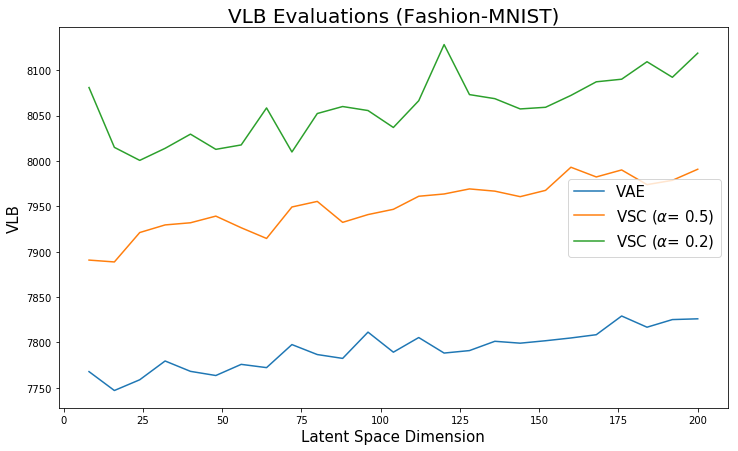

In [7]:
# Plot VLB evaluations
x = np.arange(8,201,8)
plt.figure(figsize = (12, 7))
plt.title('VLB Evaluations (Fashion-MNIST)', fontsize = 20 )
plt.plot( x , fashion_vae_vlb, label = 'VAE' )
plt.plot( x , fashion_vsc_vlb_05, label = r'VSC ($\alpha$= 0.5)' )
plt.plot( x , fashion_vsc_vlb_02, label = r'VSC ($\alpha$= 0.2)' )
plt.ylabel('VLB', fontsize = 15)
plt.xlabel('Latent Space Dimension', fontsize = 15)
plt.legend(loc='right', fontsize = 15)

## Classification Performance

### Load pretrained models

In [5]:
### MNIST 

#Load vsc-alpha 0.01 pretrained models
vsc_mnist_models_001 = []
for i in range(8,201,8):
    vsc_mnist_models_001.append( VSC(i))
    vsc_mnist_models_001[-1].load_state_dict(torch.load('../src/models/vsc_mnist_1_11_'+str(i)+'_0-001_0.01_11_.pth'))

#Load vae petrained models
vae_mnist_models = []
for i in range(8,201,8):
    vae_mnist_models.append(VAE(i))
    vae_mnist_models[-1].load_state_dict(torch.load('../src/models/vae_mnist_1_11_' + str(i) +'_0-001_11_.pth'))

### Fashion MNIST
#Load vsc-alpha 0.01 pretrained models
vsc_fashion_models_001 = []
for i in range(8,201,8):
    vsc_fashion_models_001.append( VSC(i))
    vsc_fashion_models_001[-1].load_state_dict(torch.load('../src/models/vsc_fashion_1_11_'+str(i)+'_0-001_0.01_11_.pth'))

#Load vae petrained models
vae_fashion_models = []
for i in range(8,201,8):
    vae_fashion_models.append(VAE(i))
    vae_fashion_models[-1].load_state_dict(torch.load('../src/models/vae_fashion_1_11_' + str(i) +'_0-001_11_.pth'))
    

### Load data

    2     2     2     8     0     0     5     8     5     9     4     7     3     2     0     1


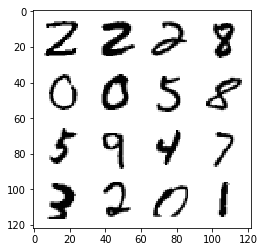

In [4]:
## Load mnist 5000 labeled training examples

BATCH_SIZE = 32

### MNIST 
mnist_train_loader = torch.utils.data.DataLoader(
                        datasets.MNIST('../data/mnist', train=True, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(np.random.permutation(60000)[:5000]) )

## FASHION
fashion_train_loader = torch.utils.data.DataLoader(
                        datasets.FashionMNIST('../data/fashion-mnist', train=True, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=False, sampler = SubsetRandomSampler(np.random.permutation(60000)[:5000]))


# Load test data

## MNIST
mnist_test_loader = torch.utils.data.DataLoader(
                        datasets.MNIST('../data/mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)

## FASHION
fashion_test_loader = torch.utils.data.DataLoader(
                        datasets.FashionMNIST('../data/fashion-mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)



dataiter = iter(mnist_train_loader)
mnist_images, mnist_labels = dataiter.next()


def imshow(img):
    npimg = 1 - img.numpy() # White background
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')

# Display images with labels
imshow(torchvision.utils.make_grid(mnist_images[:16], 4 ))
print(' '.join('%5s' % str(mnist_labels[j].item()) for j in range(16)))


Shirt Pullover Dress Sneaker Dress Sneaker   Bag Pullover Dress Sneaker Shirt Shirt Ankle boot Shirt Pullover T-shirt/top


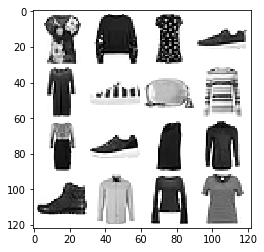

In [5]:
dataiter = iter(fashion_train_loader)
fashion_images, fashion_labels = dataiter.next()


def imshow(img):
    npimg = 1 - img.numpy() # White background
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')

# Display images with labels

clothes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

imshow(torchvision.utils.make_grid(fashion_images[:16], 4))
print(' '.join('%5s' % clothes[fashion_labels[j].item()] for j in range(16)))

In [6]:
## Classification Model 
class Classifier(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Classifier, self).__init__()
        self.layer = torch.nn.Linear(n_feature, n_output)   # single layer

    def forward(self, x):
        x = F.relu(self.layer(x))      # activation function for hidden layer
        return x
        
## For each model in the list train and test classification algorithm
def classifier_performance( list_models , train_loader , test_loader ):
    accuracy_list = []
    num_models = 1
    for model in list_models:
        
        net = Classifier(n_feature=8*num_models, n_output=10)     # define the network
        optimizer = torch.optim.SGD(net.parameters(),  lr=0.001, momentum=0.9 )
        loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

        # Train classifier
        for epoch in range(20):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                # get the inputs
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(model.forward(inputs)[1]) #encode by mu
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()

        # Test Classifier
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = net(model.forward(images)[1]) #encode by mu
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total 

        #Store accuracy
        accuracy_list.append(accuracy)
        num_models += 1 
        
    return np.asarray( accuracy_list )


In [270]:
# Calculate accuracy ( may take some time! )
vae_mnist_acc = classifier_performance( vae_mnist_models, mnist_train_loader, mnist_test_loader  ) 
vsc_mnist_acc_001 = classifier_performance( vsc_mnist_models_001, mnist_train_loader, mnist_test_loader )

# Store resulsts
np.save( '../src/results/vae-mnist-acc', vae_mnist_acc )
np.save( '../src/results/vsc-mnist-acc-001', vsc_mnist_acc_001 )

In [7]:
# Calculate accuracy ( may take some time! )
vae_fashion_acc = classifier_performance( vae_fashion_models , fashion_train_loader, fashion_test_loader ) 
vsc_fashion_acc_001 = classifier_performance( vsc_fashion_models_001, fashion_train_loader, fashion_test_loader )

# Store resulsts
np.save( '../src/results/vae-fashion-acc', vae_fashion_acc )
np.save( '../src/results/vsc-fashion-acc-001', vsc_fashion_acc_001 )

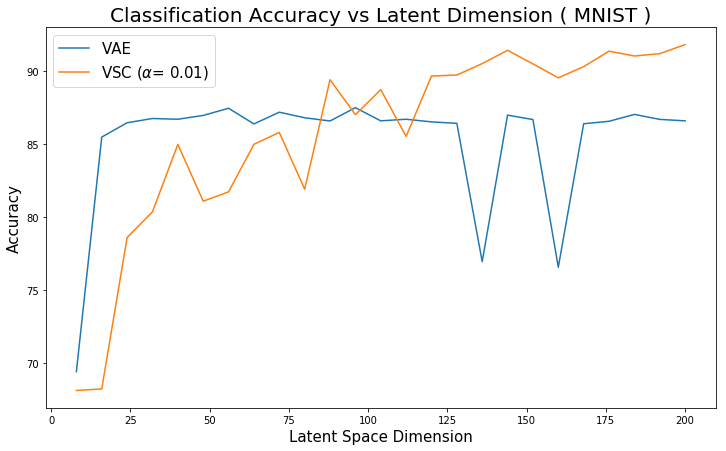

In [273]:
# Plot VLB evaluations
x = np.arange(8,201,8)
plt.figure(figsize = (12, 7))
plt.title('Classification Accuracy vs Latent Dimension ( MNIST )', fontsize = 20 )
plt.plot( x , vae_mnist_acc, label = 'VAE' )
plt.plot( x , vsc_mnist_acc_001, label = r'VSC ($\alpha$= 0.01)' )
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Latent Space Dimension', fontsize = 15)
plt.legend(loc='best', fontsize = 15)

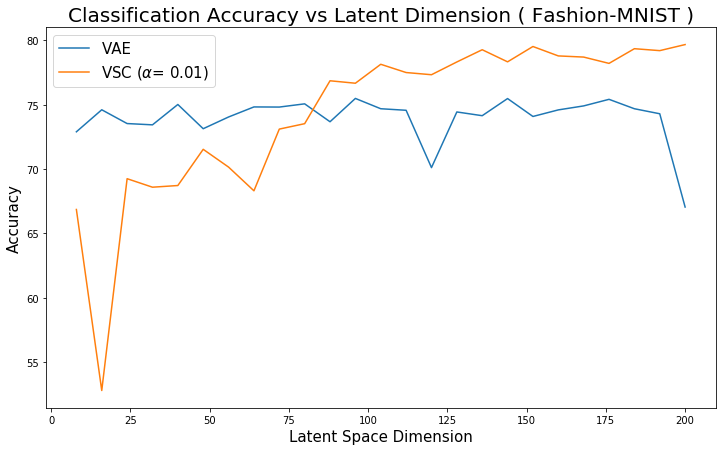

In [8]:
# Plot VLB evaluations
x = np.arange(8,201,8)
plt.figure(figsize = (12, 7))
plt.title('Classification Accuracy vs Latent Dimension ( Fashion-MNIST )', fontsize = 20 )
plt.plot( x , vae_fashion_acc, label = 'VAE' )
plt.plot( x , vsc_fashion_acc_001, label = r'VSC ($\alpha$= 0.01)' )
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Latent Space Dimension', fontsize = 15)
plt.legend(loc='best', fontsize = 15)

## Sparse Codes & Reconstructions

### Load pretrained models

In [7]:
#Load vsc-alpha 0.01 pretrained models
vsc_mnist_models_001 = []
for i in range(8,201,8):
    vsc_mnist_models_001.append( VSC(i))
    vsc_mnist_models_001[-1].load_state_dict(torch.load('../src/models/vsc_mnist_1_11_'+str(i)+'_0-001_0.01_11_.pth'))

#Load vsc-alpha 0.5 pretrained models
vsc_mnist_models_05 = []
for i in range(8,201,8):
    vsc_mnist_models_05.append( VSC(i))
    vsc_mnist_models_05[-1].load_state_dict(torch.load('../src/models/vsc_mnist_1_11_' + str(i) + '_0-001_0.5_11_.pth'))
    
#Load vsc-alpha 0.01 pretrained models
vsc_fashion_models_001 = []
for i in range(8,201,8):
    vsc_fashion_models_001.append( VSC(i))
    vsc_fashion_models_001[-1].load_state_dict(torch.load('../src/models/vsc_fashion_1_11_'+str(i)+'_0-001_0.01_11_.pth'))

#Load vsc-alpha 0.5 pretrained models
vsc_fashion_models_05 = []
for i in range(8,201,8):
    vsc_fashion_models_05.append( VSC(i))
    vsc_fashion_models_05[-1].load_state_dict(torch.load('../src/models/vsc_fashion_1_11_' + str(i) + '_0-001_0.5_11_.pth'))

### Get samples from test set

In [6]:
## Get samples from test set of MNIST , FASHION and CelebA

BATCH_SIZE = 32
## MNIST
mnist_test_loader = torch.utils.data.DataLoader(
                        datasets.MNIST('../data/mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)

## FASHION
fashion_test_loader = torch.utils.data.DataLoader(
                        datasets.FashionMNIST('../data/fashion-mnist', train=False, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=True)


# MNIST 
dataiter = iter(mnist_test_loader)
mnist_images, mnist_labels = dataiter.next()

# FASHION
dataiter = iter(fashion_test_loader)
fashion_images, fashion_labels = dataiter.next()

## Visualize Encodings

In [8]:
# Plot the z encoding 
def plot_encoding ( example_image , model , alpha , width = 1/2 ):
    
    decoded , mu, logvar,logspike  = model.forward( example_image )
    z = model.reparameterize( mu , logvar , logspike  )
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols = 3 , figsize=(21,7) )
    
    img =  torchvision.utils.make_grid( example_image ) 
    npimg = 1 - img.detach().numpy() # White background
    ax0.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax0.set_title('Input Image', fontsize = 20 )
    
    ax1.bar( np.arange(z.shape[1]) , height = z.detach().numpy()[0] , width = width, align = 'center'  )
    ax1.scatter(  np.arange(z.shape[1]) , z.detach().numpy()[0], color = 'blue' )
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], alpha) , fontsize = 20)
    
    img =  torchvision.utils.make_grid( model.decode( z ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax2.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax2.set_title('Decoded Image', fontsize = 20 )

    plt.subplots_adjust(hspace=0.5)


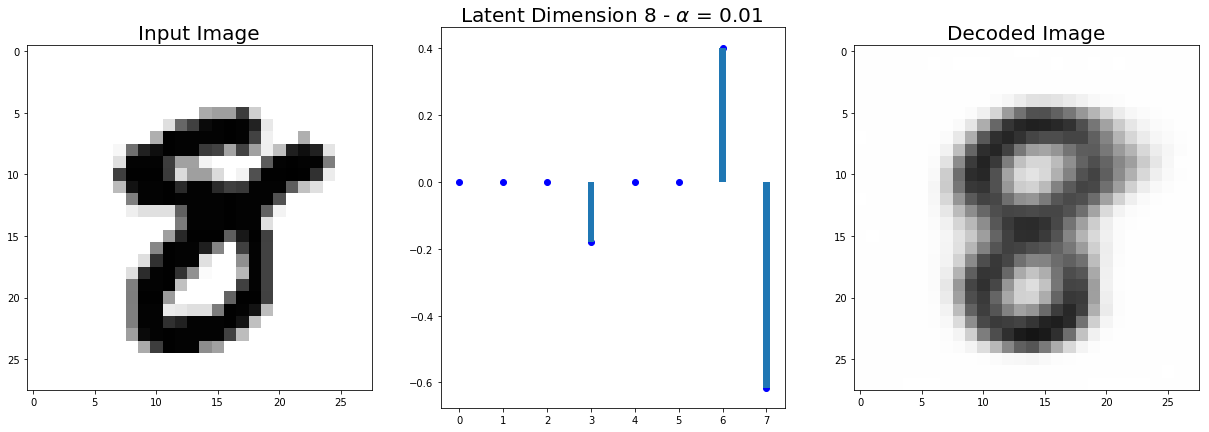

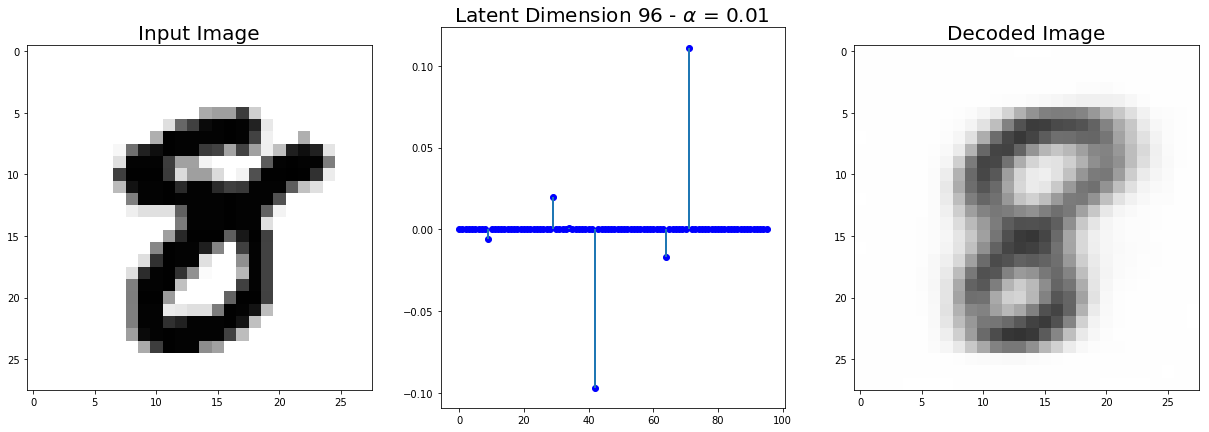

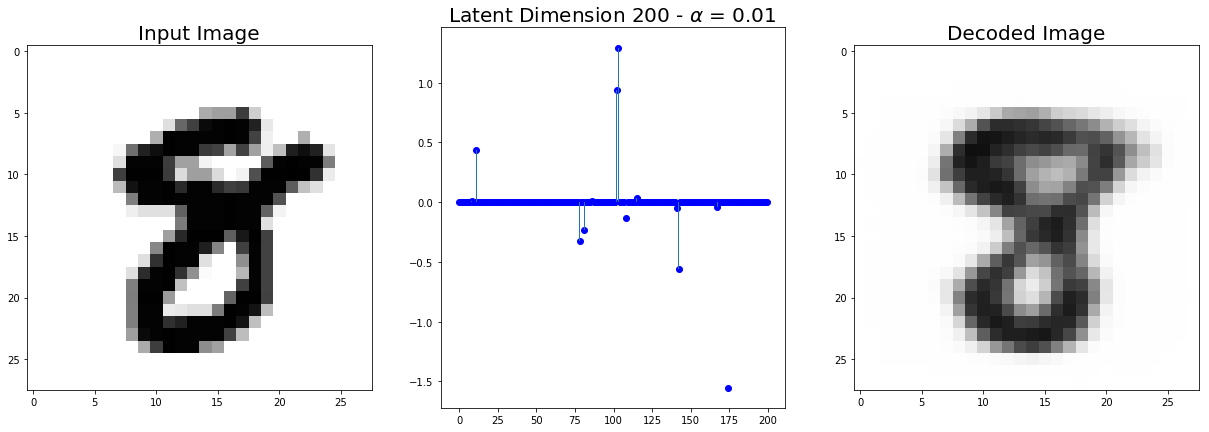

In [58]:
# Pick a sample and visualize results with alpha = 0.01
plot_encoding( mnist_images[2] , vsc_mnist_models_001[0], 0.01, width = 1/7  )
plot_encoding( mnist_images[2] , vsc_mnist_models_001[11], 0.01 )
plot_encoding( mnist_images[2] , vsc_mnist_models_001[-1], 0.01 )

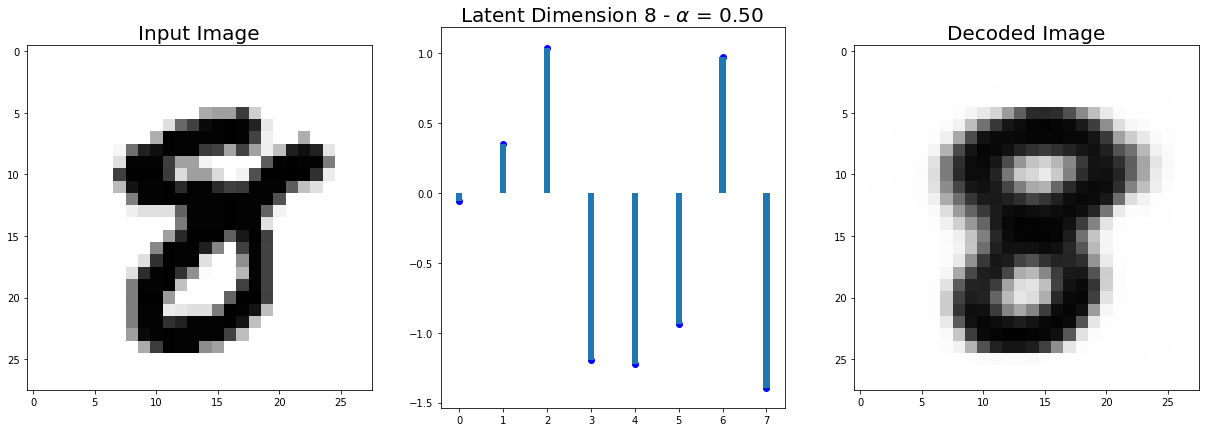

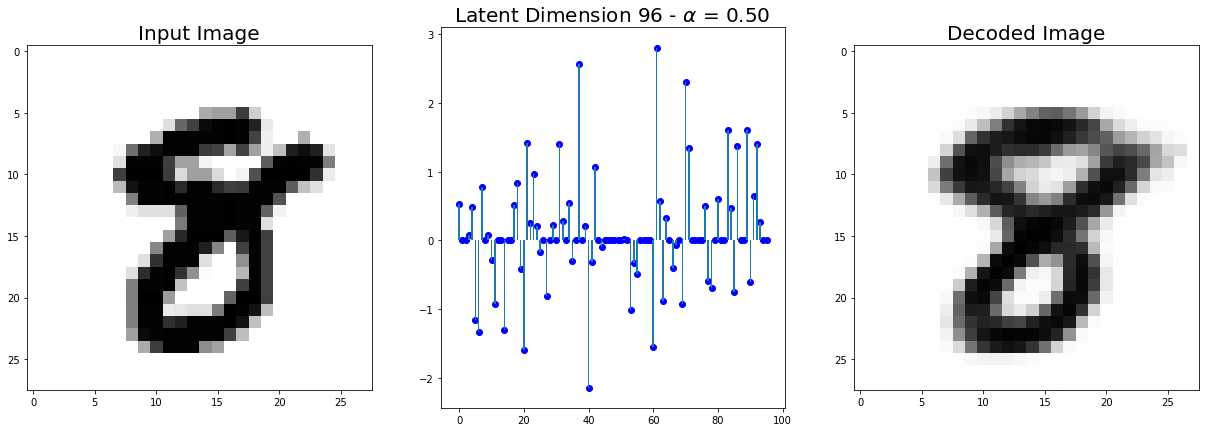

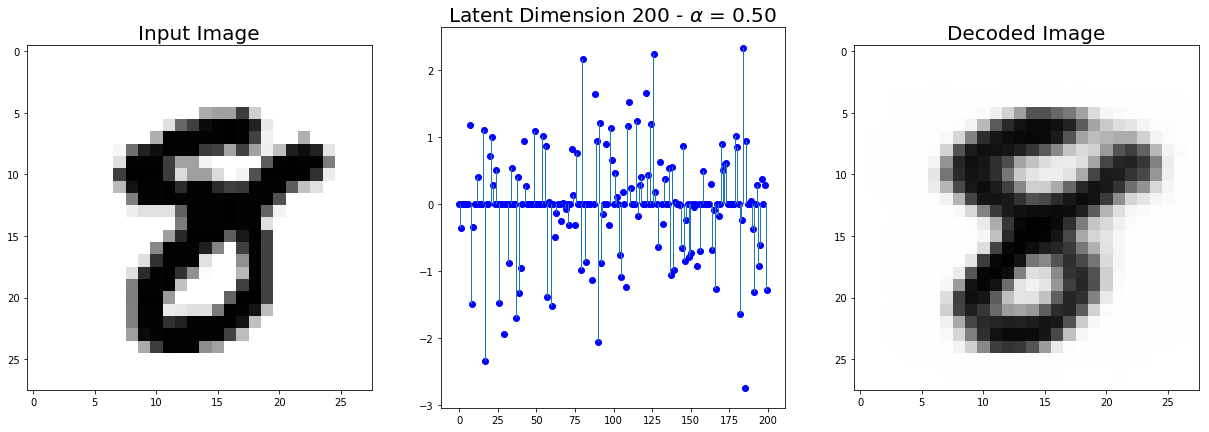

In [59]:
# Pick a sample and visualize results with alpha = 0.5
plot_encoding( mnist_images[2] , vsc_mnist_models_05[0], 0.5 , width = 1/7)
plot_encoding( mnist_images[2] , vsc_mnist_models_05[11], 0.5 )
plot_encoding( mnist_images[2] , vsc_mnist_models_05[-1], 0.5 )

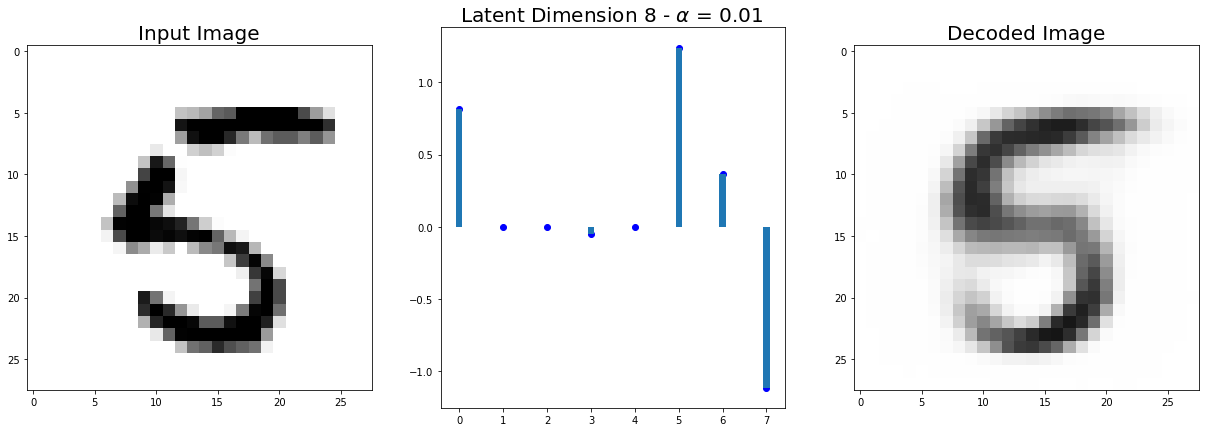

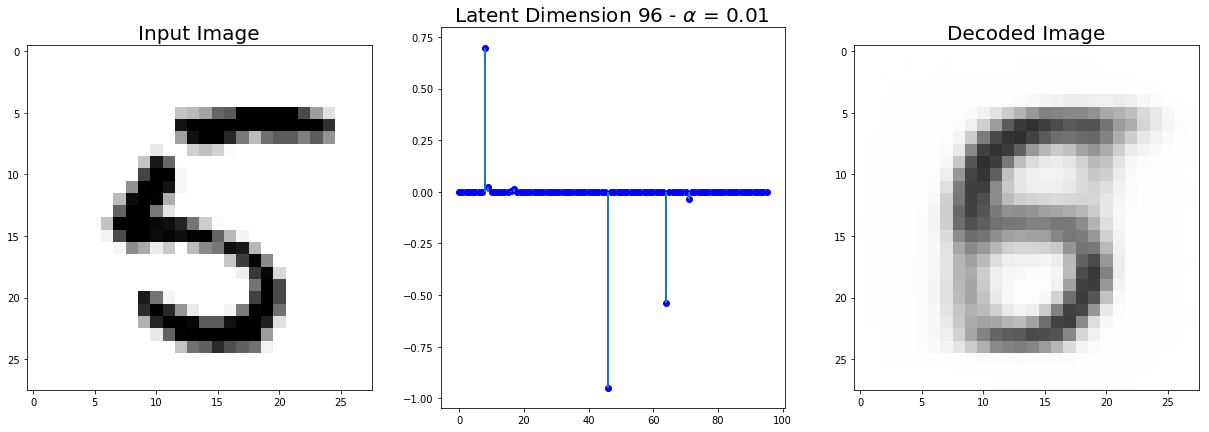

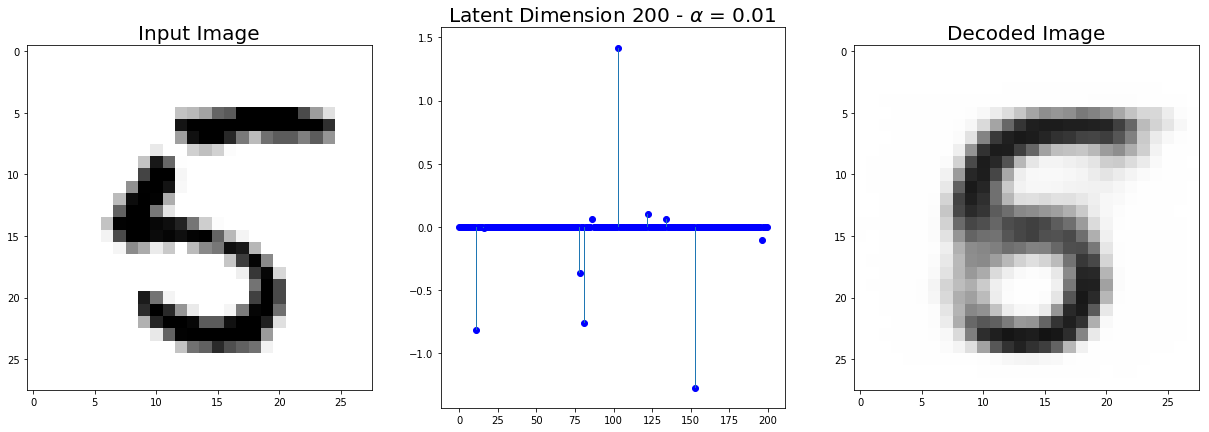

In [60]:
# Pick a sample and visualize results with alpha = 0.01
plot_encoding( mnist_images[10] , vsc_mnist_models_001[0], 0.01, width = 1/7 )
plot_encoding( mnist_images[10] , vsc_mnist_models_001[11], 0.01 )
plot_encoding( mnist_images[10] , vsc_mnist_models_001[-1], 0.01 )

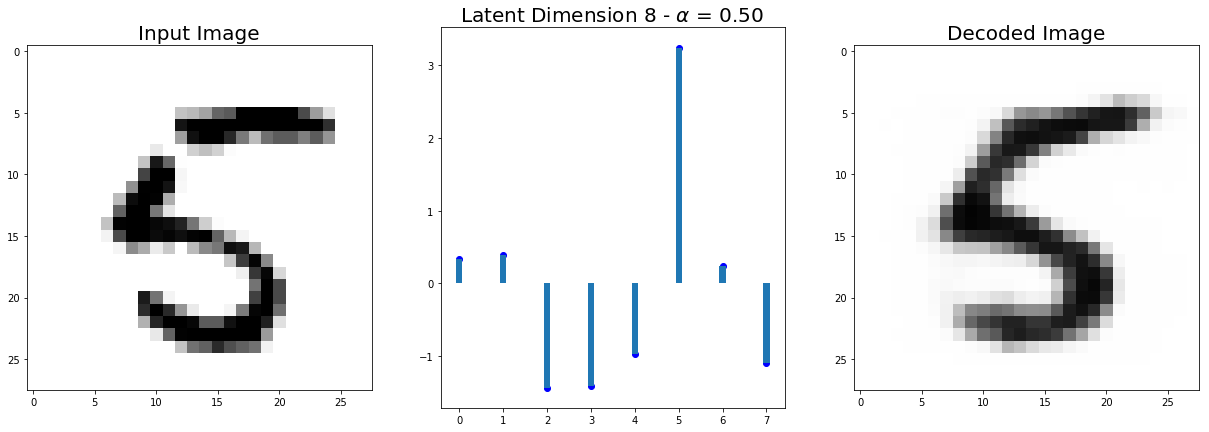

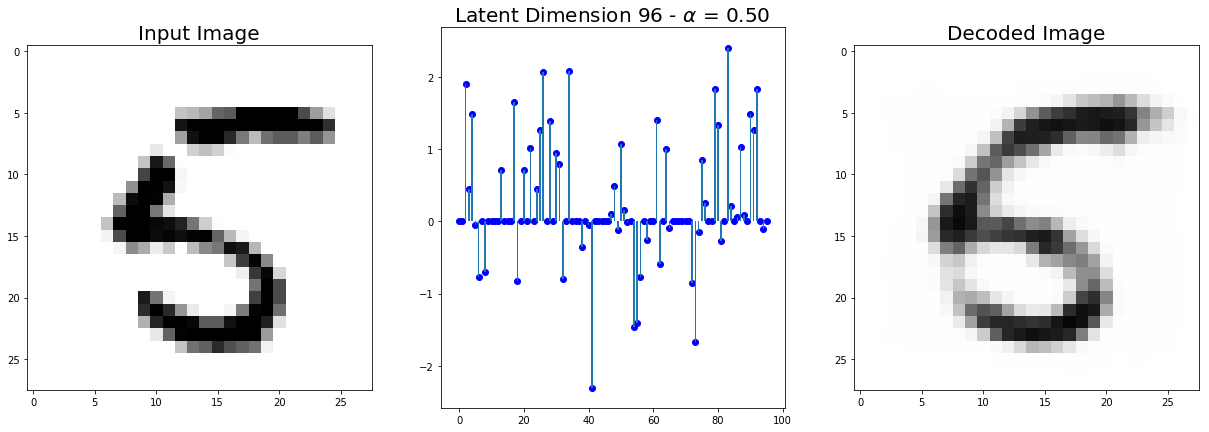

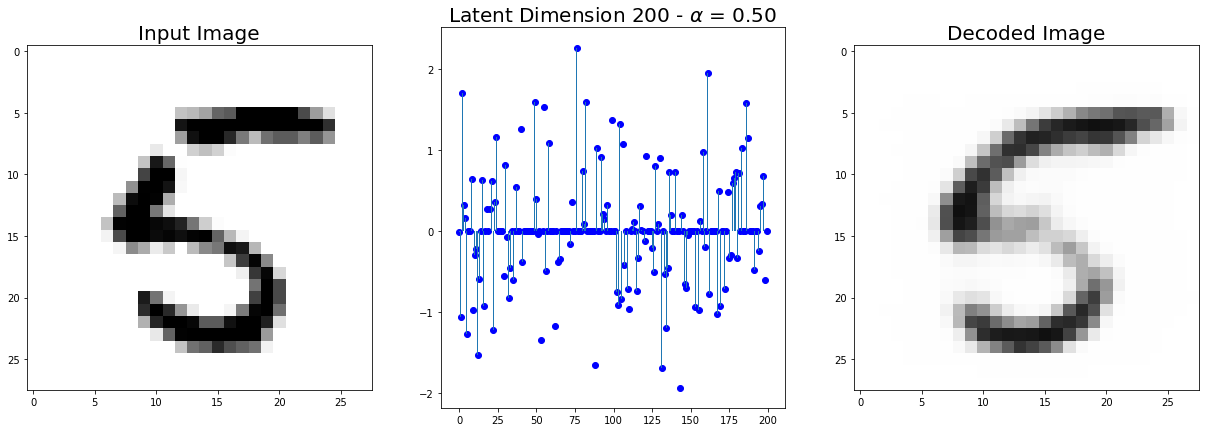

In [61]:
# Pick a sample and visualize results with alpha = 0.5
plot_encoding( mnist_images[10] , vsc_mnist_models_05[0], 0.5, width = 1/7)
plot_encoding( mnist_images[10] , vsc_mnist_models_05[11], 0.5 )
plot_encoding( mnist_images[10] , vsc_mnist_models_05[-1], 0.5 )

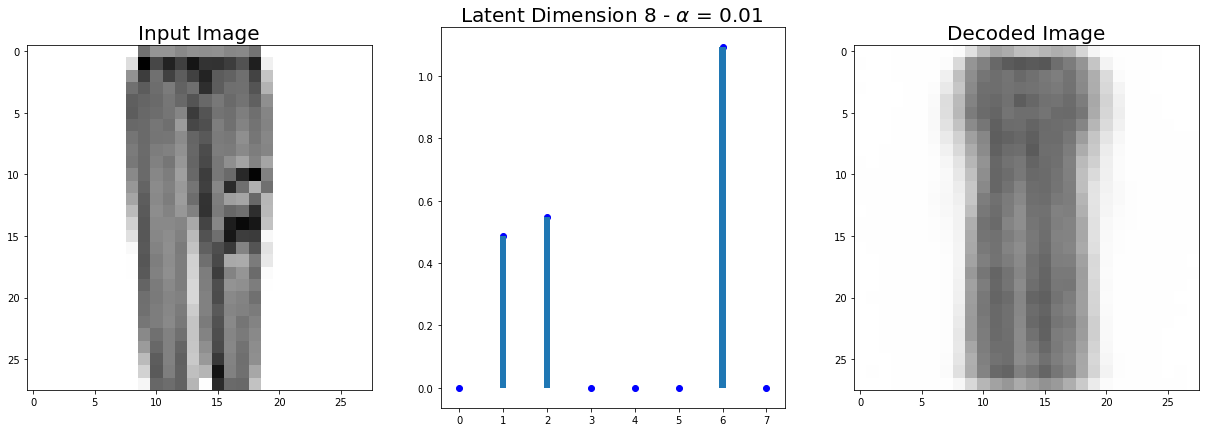

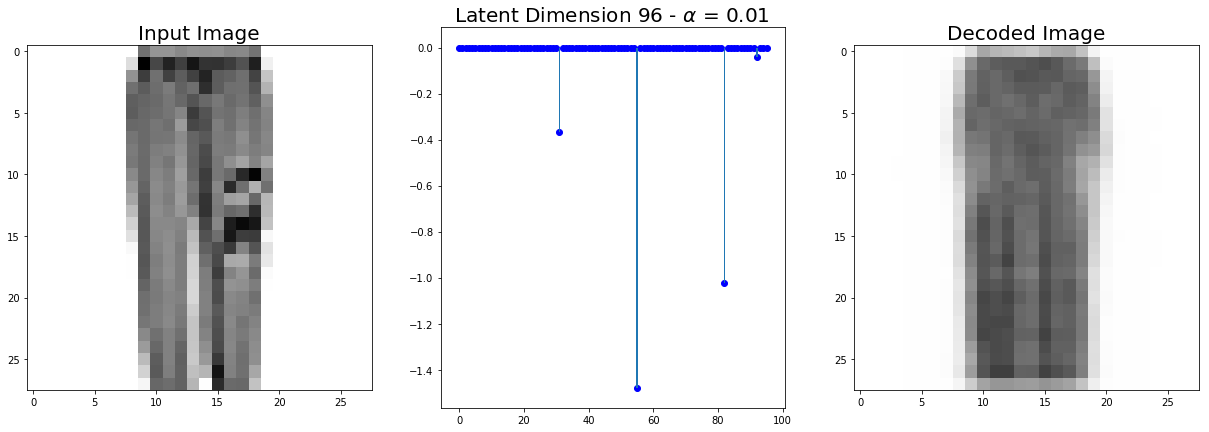

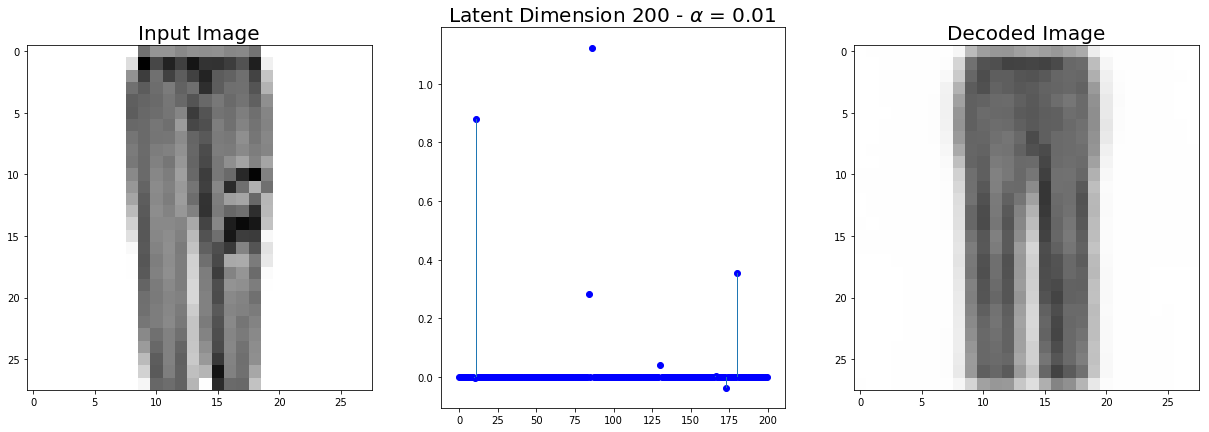

In [60]:
# Pick a sample and visualize results with alpha = 0.01
example = 24
plot_encoding( fashion_images[example] , vsc_fashion_models_001[0], 0.01, width = 1/7  )
plot_encoding( fashion_images[example] , vsc_fashion_models_001[11], 0.01 )
plot_encoding( fashion_images[example] , vsc_fashion_models_001[-1], 0.01 )

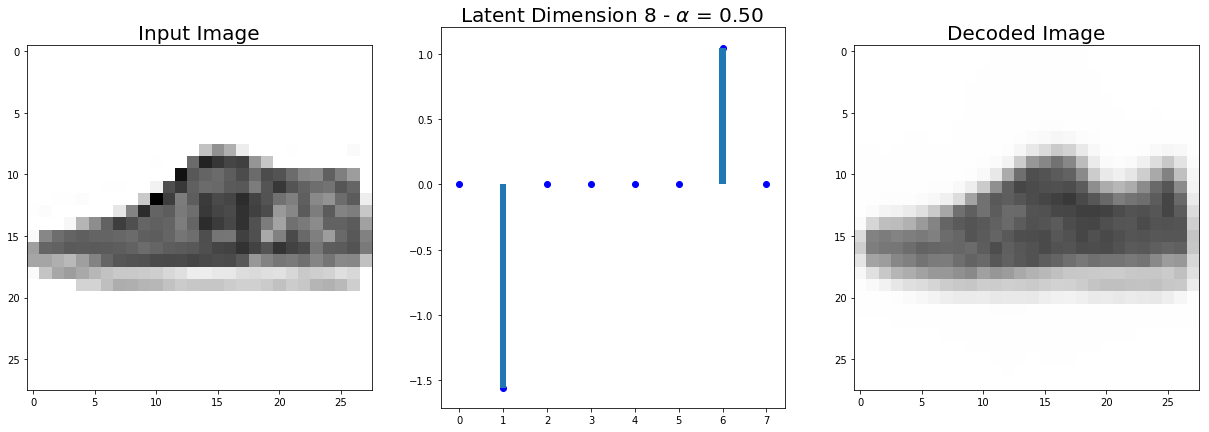

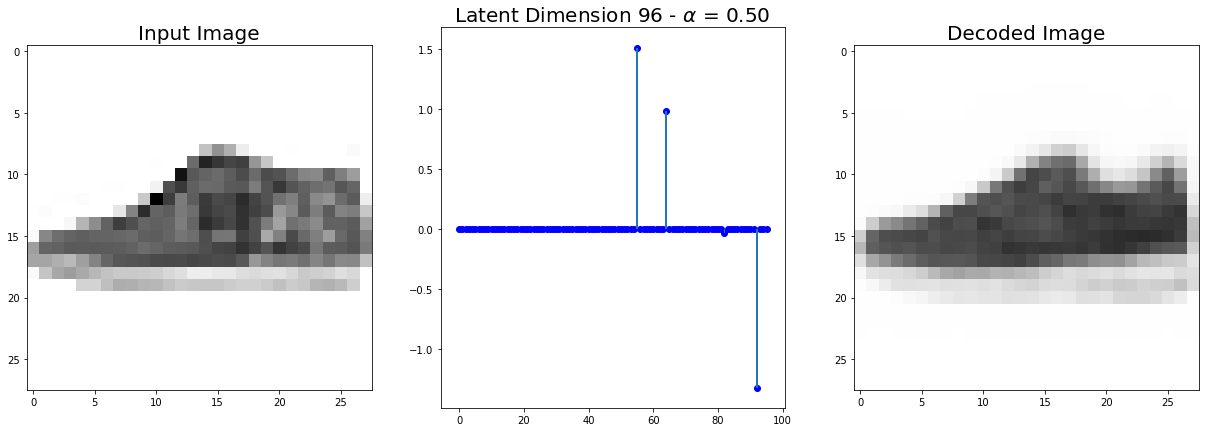

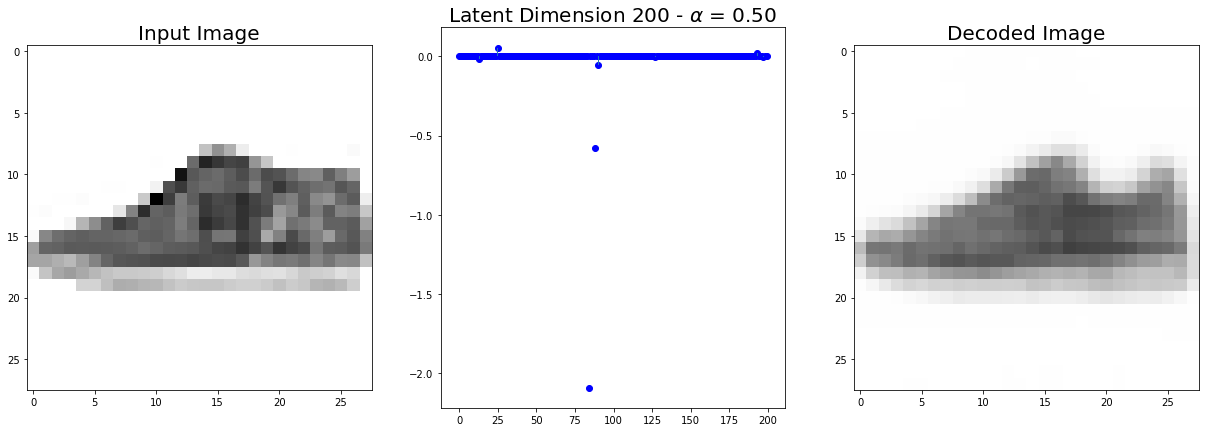

In [10]:
# Pick a sample and visualize results with alpha = 0.5
plot_encoding( fashion_images[1] , vsc_fashion_models_001[0], 0.5, width = 1/7  )
plot_encoding( fashion_images[1] , vsc_fashion_models_001[11], 0.5 )
plot_encoding( fashion_images[1] , vsc_fashion_models_001[-1], 0.5 )

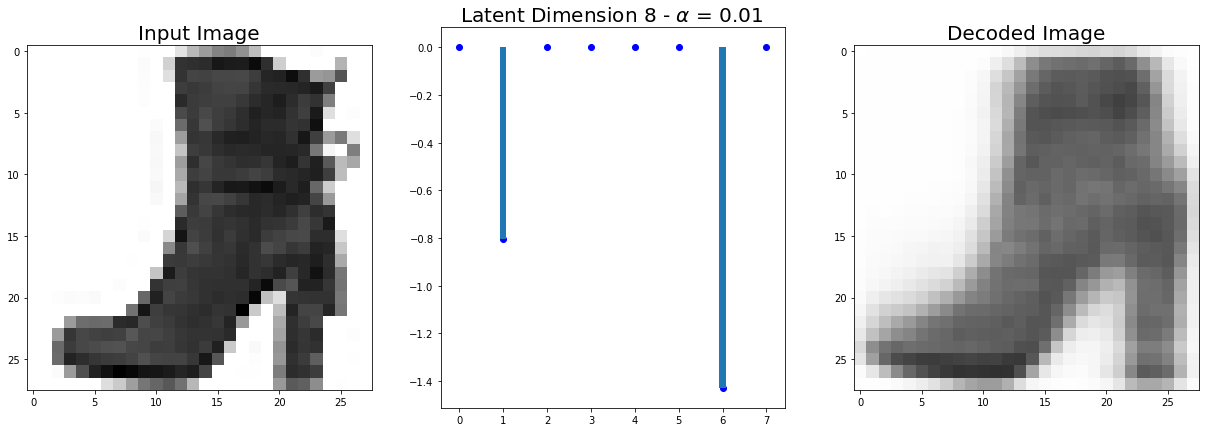

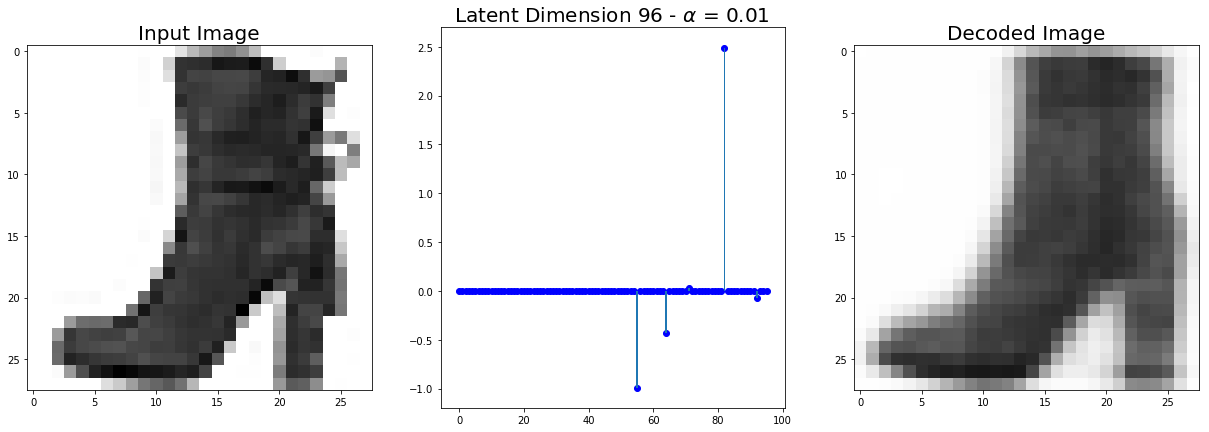

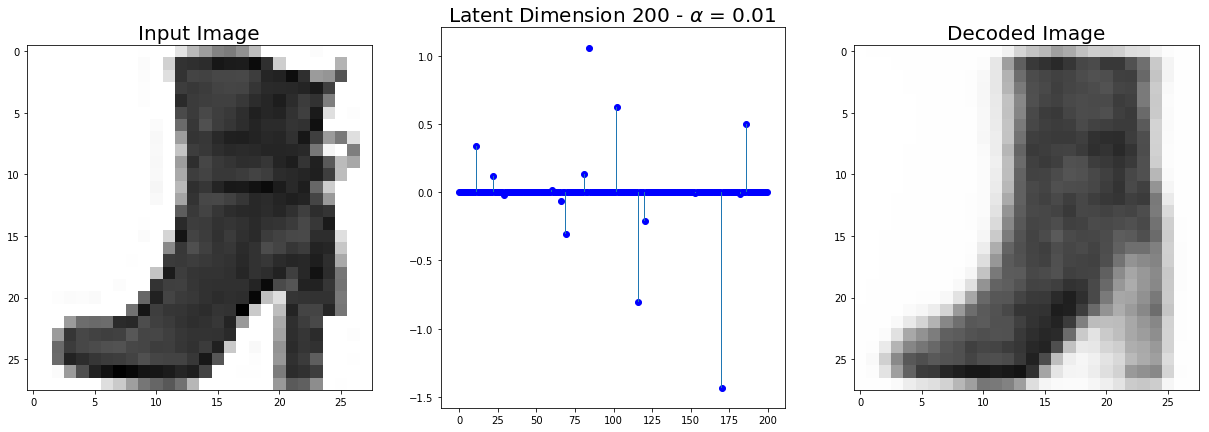

In [11]:
# Pick a sample and visualize results with alpha = 0.01
plot_encoding( fashion_images[10] , vsc_fashion_models_001[0], 0.01, width = 1/7  )
plot_encoding( fashion_images[10] , vsc_fashion_models_001[11], 0.01 )
plot_encoding( fashion_images[10] , vsc_fashion_models_001[-1], 0.01 )

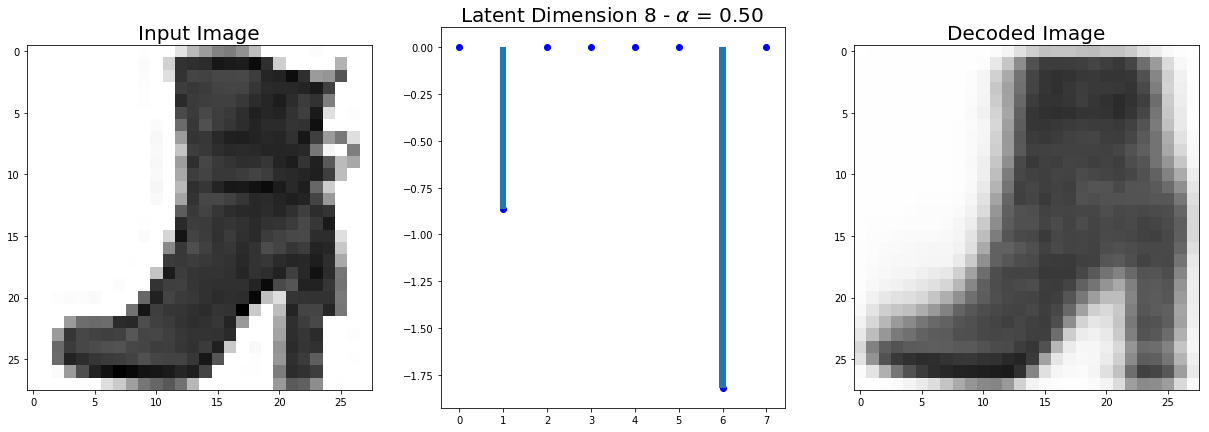

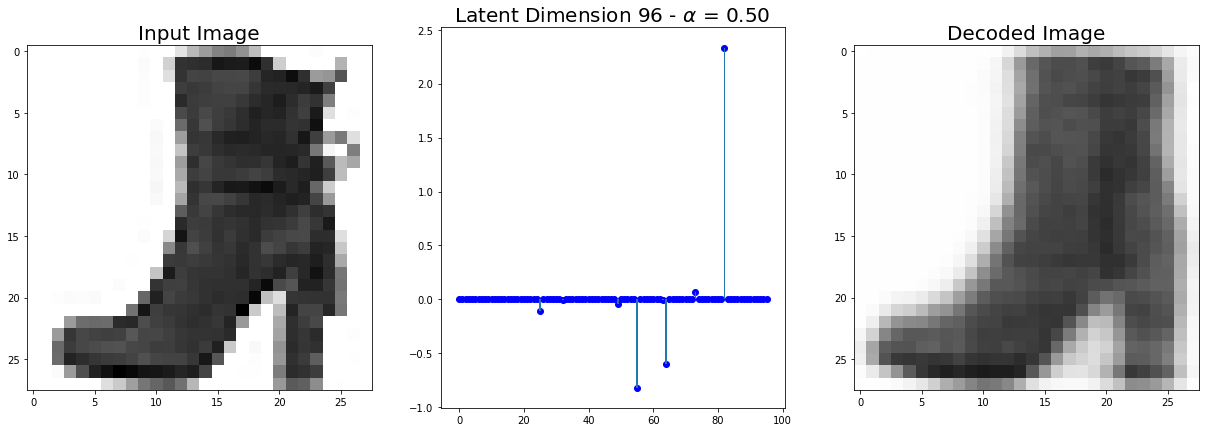

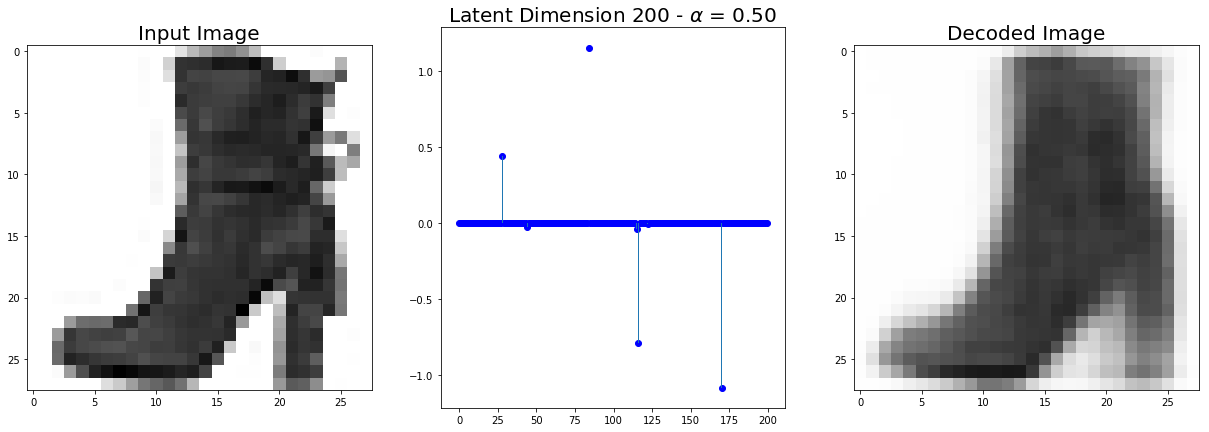

In [12]:
# Pick a sample and visualize results with alpha = 0.5
plot_encoding( fashion_images[10] , vsc_fashion_models_001[0], 0.5, width = 1/7  )
plot_encoding( fashion_images[10] , vsc_fashion_models_001[11], 0.5 )
plot_encoding( fashion_images[10] , vsc_fashion_models_001[-1], 0.5 )

## Interpretation of the Sparse Codes

We encode examples from the test sets of the MNIST, Fashion-MNIST and CelebA datasets with VSC trained with prior spike probability $\alpha = 0.01$. 
The MNIST and Fashion-MNIST were encoded in 200 latent dimensions and CelebA using 800 . 

In [10]:
#Load vsc-alpha 0.01 pretrained models
vsc_mnist_models_001 = []
for i in range(8,201,8):
    vsc_mnist_models_001.append( VSC(i))
    vsc_mnist_models_001[-1].load_state_dict(torch.load('../src/models/vsc_mnist_1_11_'+str(i)+'_0-001_0.01_11_.pth'))

In [12]:
#Load vsc-alpha 0.01 pretrained models
vsc_fashion_models_001 = []
for i in range(8,201,8):
    vsc_fashion_models_001.append( VSC(i))
    vsc_fashion_models_001[-1].load_state_dict(torch.load('../src/models/vsc_fashion_1_11_'+str(i)+'_0-001_0.01_11_.pth'))

In [126]:
## Get samples from test set of MNIST , FASHION and CelebA

# MNIST 
dataiter = iter(mnist_test_loader)
mnist_images, mnist_labels = dataiter.next()

# FASHION
dataiter = iter(fashion_test_loader)
fashion_images, fashion_labels = dataiter.next()

In [51]:
def plot_interpretability ( example_image , model , alpha , width = 1/2 ):
    
    decoded , mu, logvar,logspike  = model.forward( example_image )
    z = model.reparameterize( mu , logvar , logspike  )
    
    # Modify the highest value in encoding
    minn = z.min().detach().numpy()
    maxx = z.max().detach().numpy()
    max_ind = torch.argmax( z ).item()

    z1 = z.clone()
    z1[ 0, max_ind ] *= 0.01
    z2 = z.clone()
    z2[ 0, max_ind  ] *= -0.5
    
    fig, ax = plt.subplots(nrows=2, ncols = 3 , figsize=(21,14) )
    
    #Plot encodings
    ax[0,0].bar( np.arange(z.shape[1]) , height = z.detach().numpy()[0] , width = width  )
    ax[0,0].scatter(  np.arange(z.shape[1]) , z.detach().numpy()[0], color = 'blue' )
    ax[0,0].scatter(  max_ind , z[0, max_ind].detach().numpy() , color = 'red' )
    ax[0,0].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], alpha) , fontsize = 20)
    ax[0,0].set_ylim(minn -0.1,maxx + 0.1)
    
    
    ax[0,1].bar( np.arange(z1.shape[1]) , height = z1.detach().numpy()[0] , width = width )
    ax[0,1].scatter(  np.arange(z1.shape[1]) , z1.detach().numpy()[0], color = 'blue' )
    ax[0,1].scatter(  max_ind , z1[0, max_ind].detach().numpy() , color = 'red' )
    ax[0,1].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], alpha) , fontsize = 20)
    ax[0,1].set_ylim(minn -0.1,maxx + 0.1)
    
    ax[0,2].bar( np.arange(z2.shape[1]) , height = z2.detach().numpy()[0] , width = width )
    ax[0,2].scatter(  np.arange(z2.shape[1]) , z2.detach().numpy()[0], color = 'blue' )
    ax[0,2].scatter(  max_ind , z2[0, max_ind].detach().numpy() , color = 'red' )
    ax[0,2].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], alpha) , fontsize = 20)
    ax[0,2].set_ylim(minn -0.1,maxx + 0.1)
    
    
    #Plot decoded images
    img =  torchvision.utils.make_grid( model.decode( z ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax[1,0].imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax[1,0].set_title('Decoded Image', fontsize = 20 )
    
    img =  torchvision.utils.make_grid( model.decode( z1 ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax[1,1].imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax[1,1].set_title('Decoded Image', fontsize = 20 )
    
    img =  torchvision.utils.make_grid( model.decode( z2 ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax[1,2].imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax[1,2].set_title('Decoded Image', fontsize = 20 )

    plt.subplots_adjust(hspace=0.1)

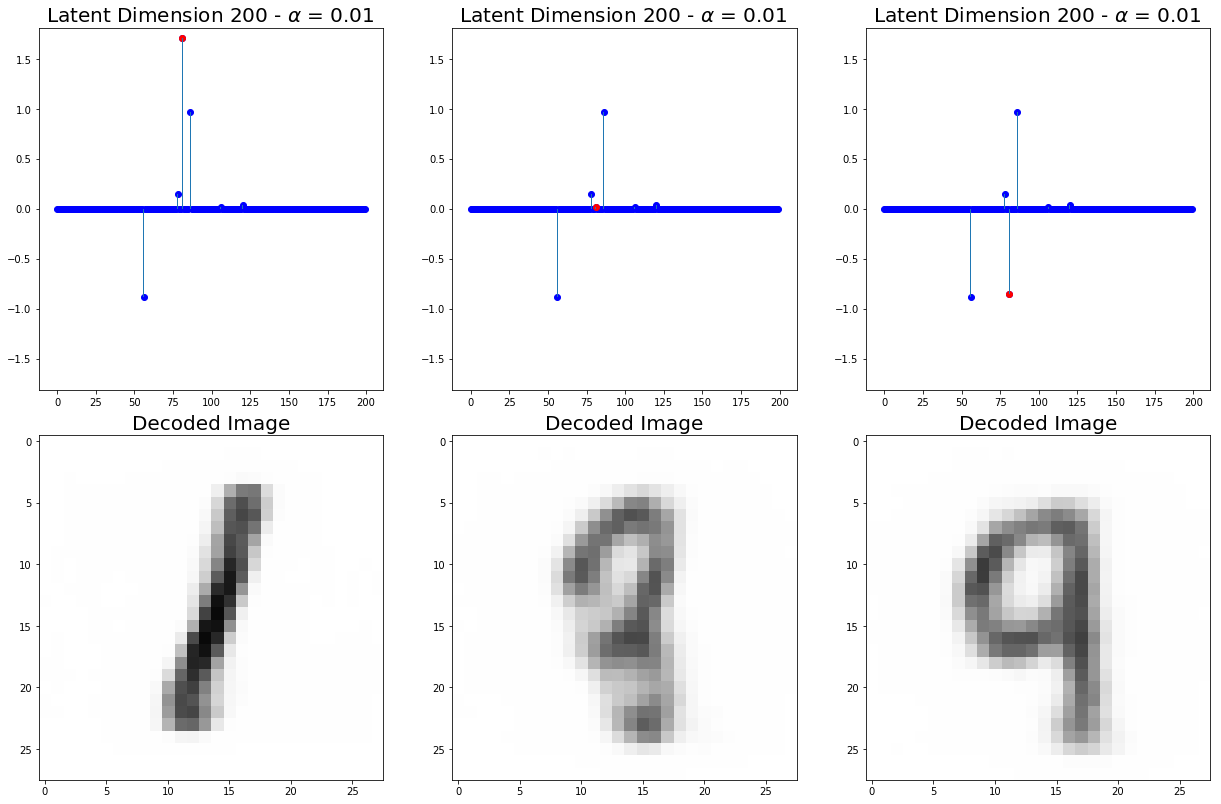

In [28]:
plot_interpretability( mnist_images[9] , vsc_mnist_models_001[-1], 0.01, width = 1/1.5)

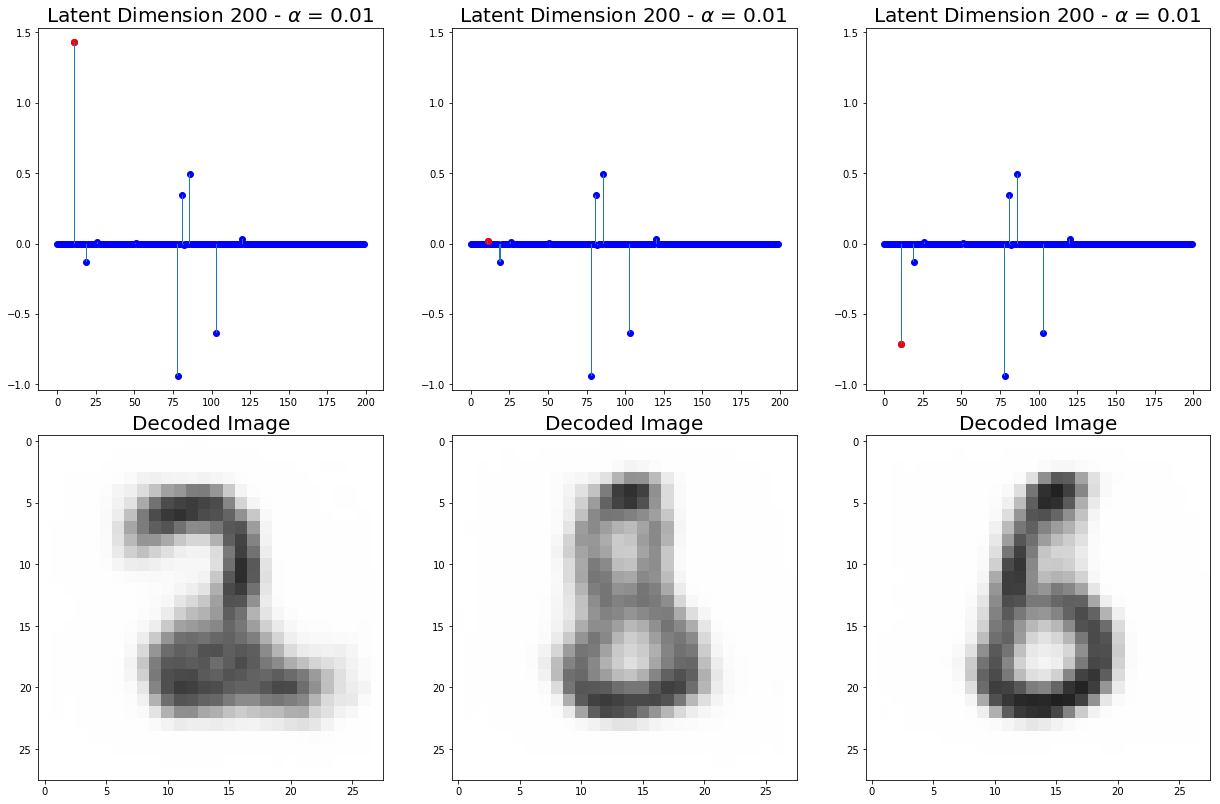

In [32]:
plot_interpretability( mnist_images[14] , vsc_mnist_models_001[-1], 0.01, width = 1/1.5)

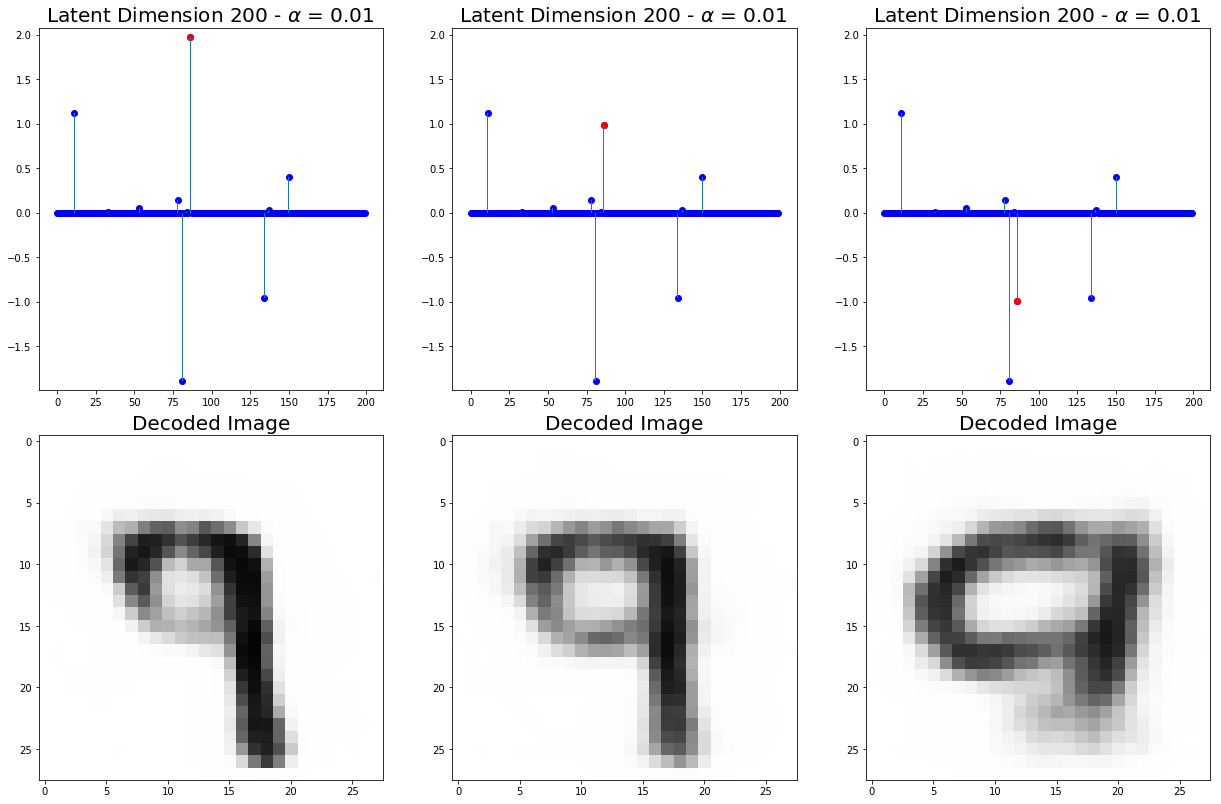

In [229]:
plot_interpretability( mnist_images[19] , vsc_mnist_models_001[-1], 0.01, width = 1/1.5)

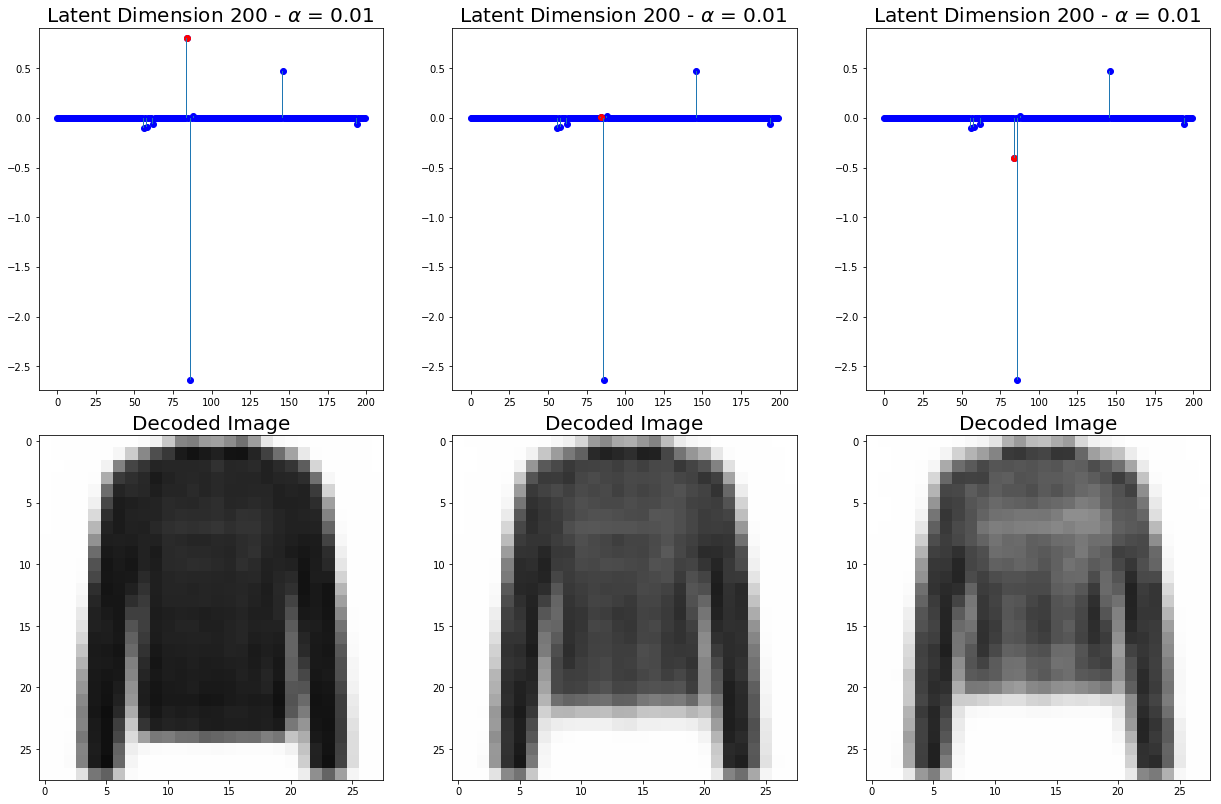

In [19]:
plot_interpretability( fashion_images[15] , vsc_fashion_models_001[-1], 0.01, width = 1/1.5)

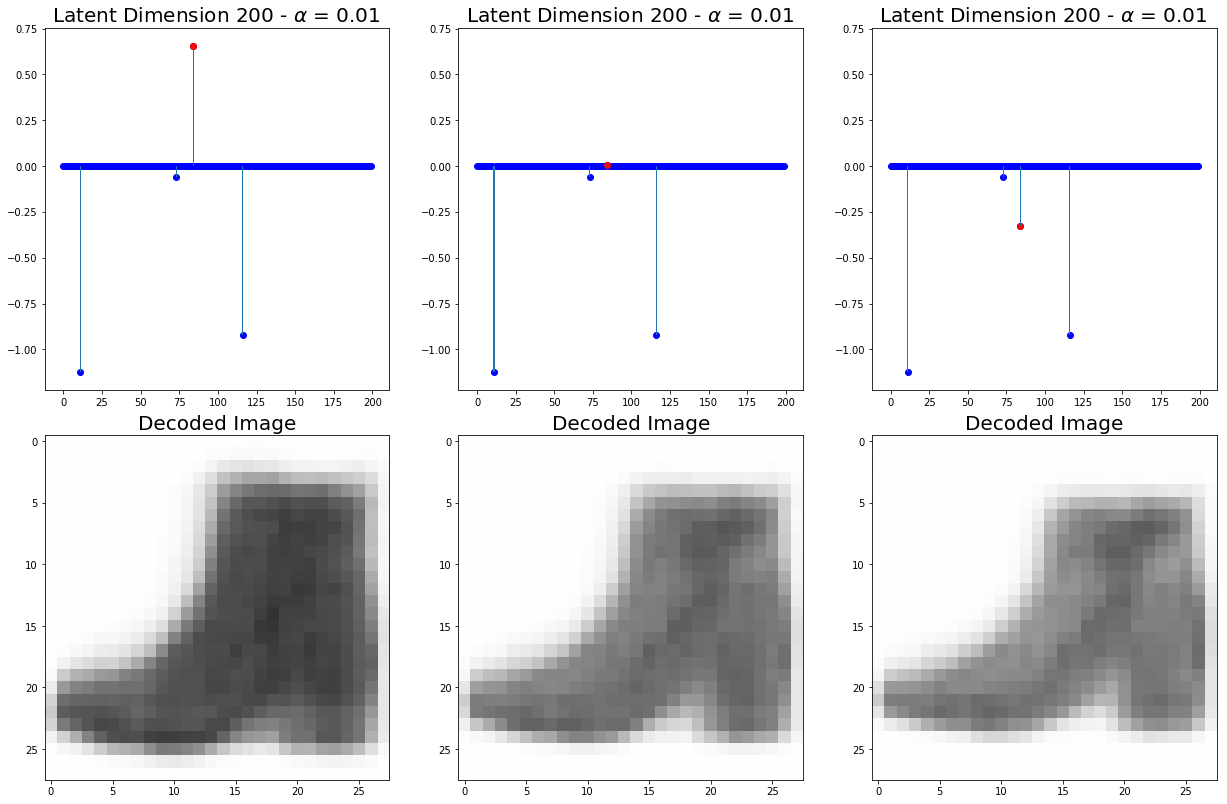

In [30]:
plot_interpretability( fashion_images[19] , vsc_fashion_models_001[-1], 0.01, width = 1/1.5)

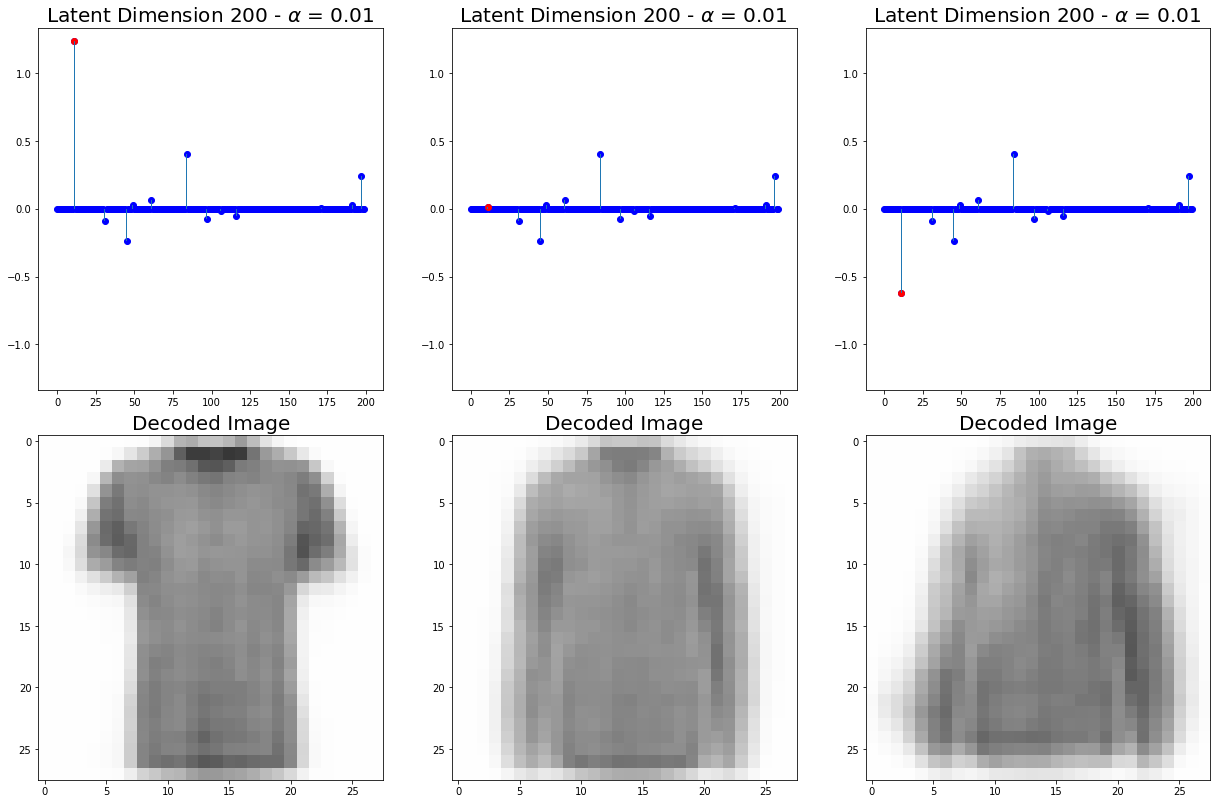

In [50]:
plot_interpretability( fashion_images[11] , vsc_fashion_models_001[-1], 0.01, width = 1/1.5)

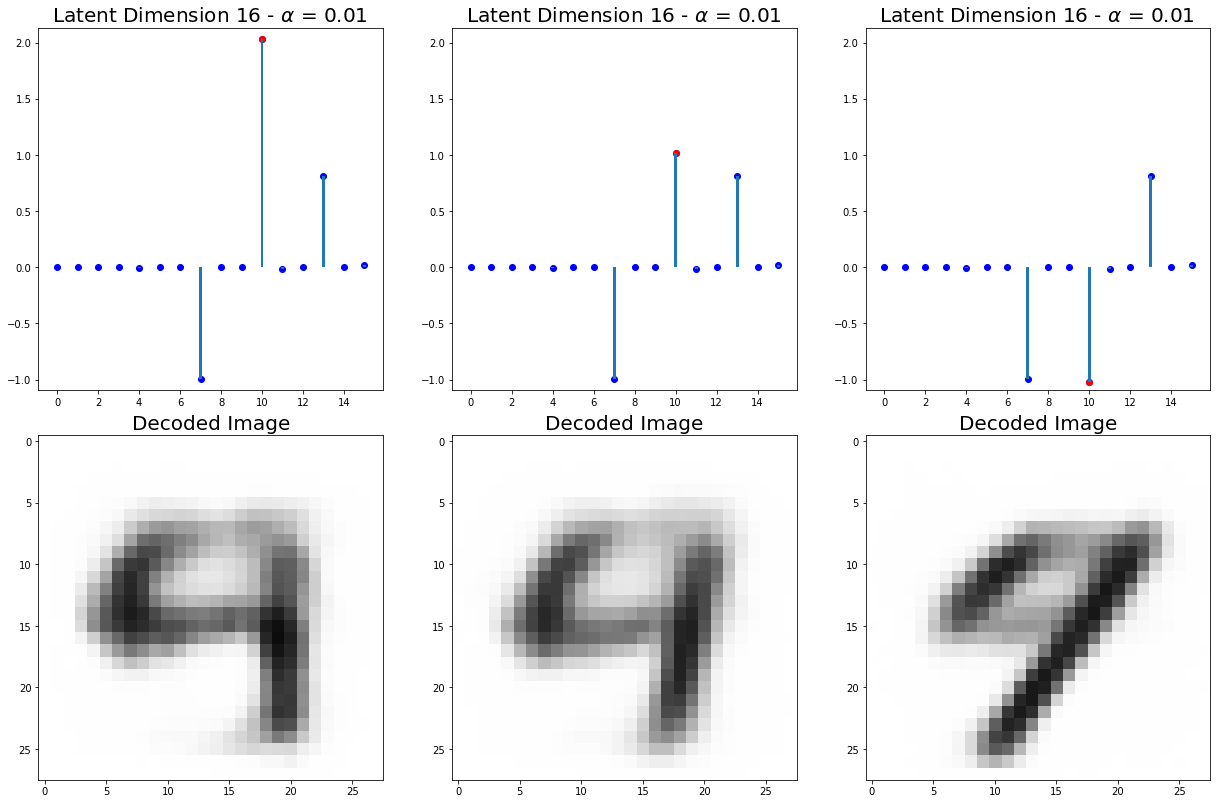

In [234]:
plot_interpretability( mnist_images[0] , vsc_mnist_models_001[1], 0.01, width = 1/7)

## Interactive Manipulation of Low-dimensional Latent Space

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
import ipywidgets as widgets


def plot_result( x0, x1, x2, x3, x4, x5, x6, x7):
    
    z = torch.from_numpy(np.asarray([x0,x1,x2,x3,x4,x5,x6,x7])).view(1,-1)
    z = z.type(torch.FloatTensor)
    
    fig, ax = plt.subplots(nrows=1, ncols = 2 , figsize=(10,5 ) )
    
    #Plot encodings
    ax[0].bar( np.arange(z.shape[1]) , height = z.detach().numpy()[0] , width = 1/7  )
    ax[0].scatter(  np.arange(z.shape[1]) , z.detach().numpy()[0], color = 'blue' )
    ax[0].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], 0.01) , fontsize = 20)
    ax[0].set_ylim(-3.1, 3.1)
    
    #Plot decoded images
    img =  torchvision.utils.make_grid( vsc_mnist_models_001[0].decode( z ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax[1].imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax[1].set_title('Decoded Image', fontsize = 20 )
    

interact(plot_result ,
                x0 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x1 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x2 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x3 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x4 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x5 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x6 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x7 = FloatSlider(min=-3.0, max=3.0, step=0.5) )

A Jupyter Widget

<function __main__.plot_result>

In [52]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
import ipywidgets as widgets

def plot_result( x0, x1, x2, x3, x4, x5, x6, x7):
    
    z = torch.from_numpy(np.asarray([x0,x1,x2,x3,x4,x5,x6,x7])).view(1,-1)
    z = z.type(torch.FloatTensor)
    
    fig, ax = plt.subplots(nrows=1, ncols = 2 , figsize=(10,5 ) )
    
    #Plot encodings
    ax[0].bar( np.arange(z.shape[1]) , height = z.detach().numpy()[0] , width = 1/7  )
    ax[0].scatter(  np.arange(z.shape[1]) , z.detach().numpy()[0], color = 'blue' )
    ax[0].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], 0.01) , fontsize = 20)
    ax[0].set_ylim(-3.1, 3.1)
    
    #Plot decoded images
    img =  torchvision.utils.make_grid( vsc_fashion_models_001[0].decode( z ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax[1].imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax[1].set_title('Decoded Image', fontsize = 20 )
    

interact(plot_result ,
                x0 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x1 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x2 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x3 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x4 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x5 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x6 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x7 = FloatSlider(min=-3.0, max=3.0, step=0.5) )

A Jupyter Widget

<function __main__.plot_result>

## Latent Traversals

In [14]:
import imageio

def plot_interpretability_traversal ( example_image , model , alpha , length , delta, width = 1/2 ):
    
    decoded , mu, logvar,logspike  = model.forward( example_image )
    z = model.reparameterize( mu , logvar , logspike  )
    
    # Modify the highest value in encoding
    minn = z.min().detach().numpy()
    maxx = z.max().detach().numpy()
    max_ind = torch.argmax( z ).item()
    
    images = []
    for i in range(length):

        z1 = z.clone()

        fig, ax = plt.subplots(nrows=1, ncols = 2 , figsize=(10,5 ) )
    
        #Plot encodings
        ax[0].bar( np.arange(z1.shape[1]) , height = z1.detach().numpy()[0] , width = width  )
        ax[0].scatter(  np.arange(z1.shape[1]) , z1.detach().numpy()[0], color = 'blue' )
        ax[0].scatter(  max_ind , z1[0, max_ind].detach().numpy() , color = 'red' )
        ax[0].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], alpha) , fontsize = 20)
        ax[0].set_ylim(-2.5,2.5)
    

        #Plot decoded images
        img =  torchvision.utils.make_grid( model.decode( z1 ).view(1,1,28,28) ) 
        npimg = 1 - img.detach().numpy() # White background
        ax[1].imshow(np.transpose(npimg, (1, 2, 0)))
        ax[1].set_title('Decoded Image', fontsize = 20 )

        plt.savefig( 'Latent'+str(i)+'.png' ,  dpi = 600)
        plt.close()
        images.append(imageio.imread('Latent'+str(i)+'.png'))
        
        z[ 0, max_ind ] -= delta
        
    imageio.mimsave('movie.gif', images)

In [17]:
plot_interpretability_traversal( fashion_images[3] , vsc_fashion_models_001[-1], 0.01, 40, 0.05,  width = 1/2)

In [11]:
import random
def plot_horizontal_traversal ( example_image , model , alpha , length , delta , encoding_info = False ):
    
    decoded , mu, logvar,logspike  = model.forward( example_image )
    z = model.reparameterize( mu , logvar , logspike  )
    

    # Non zero elements
    non_zero = []
    for i in range(z.shape[1]):
        if np.abs(z[0,i].detach().numpy()) > 1e-4:
            non_zero.append(i)

    # Pick a random non zero coordinate
    ind = random.choice(non_zero)
    
    # Encoding information
    if encoding_info :
        
        print( ind )
        print( non_zero)
        plt.figure(figsize = (5,5))
        plt.plot(np.arange(z.shape[1]), z.detach().numpy()[0,:])
        plt.show()

    # Produce result images
    images = []
    for i in range(length):

        z1 = z.clone()
        img =  torchvision.utils.make_grid( model.decode( z1 ).view(1,1,28,28) ) 
        npimg = 1 - img.detach().numpy() # White background
        images.append(np.transpose(npimg, (1, 2, 0)))
        z[ 0, ind ] -= delta
        
    traversal = np.concatenate(images, axis = 1 )
        
    plt.axis('off')
    plt.imshow(traversal)
    plt.show()
    
    return traversal

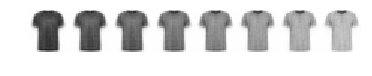

In [168]:
im1 = plot_horizontal_traversal( fashion_images[9] , vsc_fashion_models_001[-1], 0.01, 8 , 0.2)

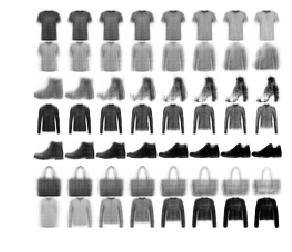

In [510]:
final = np.concatenate( [im1,im2,im4,im3,im5,im6,im7], axis = 0 )
np.save('final_fashion_matrix.npy',final)
plt.axis('off')
plt.imshow(final)
plt.savefig('Fashion-traversal')

## VSC Conditional Sampling

In [6]:
#Load models trained for 100 epochs
vsc_mnist_models_001 = VSC(200)
vsc_mnist_models_001.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_200_0-001_0.01_100_.pth'))

vsc_fashion_models_001 = VSC(200)
vsc_fashion_models_001.load_state_dict(torch.load('../src/models/vsc_fashion_1_500_200_0-001_0.01_100_.pth'))

vsc_mnist_models_05 = VSC(200)
vsc_mnist_models_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_500_200_0-001_0.5_500_.pth'))

vsc_fashion_models_05 = VSC(200)
vsc_fashion_models_05.load_state_dict(torch.load('../src/models/vsc_fashion_1_500_200_0-001_0.5_500_.pth'))

In [212]:
def vsc_conditional_sampling ( example_image , model , length = 6, percentage = 0.8 ):
    
    decoded , mu, logvar,logspike  = model.forward( example_image )
    z = model.reparameterize( mu , logvar , logspike  )
    
    plt.figure(figsize = (2,2))
    plt.axis('off')
    img = torchvision.utils.make_grid( example_image.view(1,1,28,28)).numpy()
    
    plt.imshow(np.transpose(1-img,(1,2,0)))
    plt.show()

    # Non zero elements
    non_zero = []
    for i in range(z.shape[1]):
        if np.abs(z[0,i].detach().numpy()) > 1e-4:
            non_zero.append(i)

    # Pick a set of random non zero coordinates of percentage of the activated dimensions
    ind = np.random.choice(non_zero, int(percentage * len(non_zero) ) )

    # Produce result images
    images = []
    for _ in range(length):
    
        # Obtain samples for each activated dimension
        z1 = z.clone()
        for i in ind:
            z1[0,i] = np.random.normal() # Prior Gasussian Components
            
        img =  torchvision.utils.make_grid( model.decode( z1 ).view(1,1,28,28) ) 
        npimg = 1 - img.detach().numpy() # White background
        images.append(np.transpose(npimg, (1, 2, 0)))
        
    traversal = np.concatenate(images, axis = 1 )
    
    plt.figure(figsize = (14,10))
    plt.axis('off')
    plt.imshow(traversal)
    plt.show()
    
    return traversal

### Models VSC - $\alpha$ = 0.01 - 100 epochs

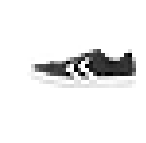

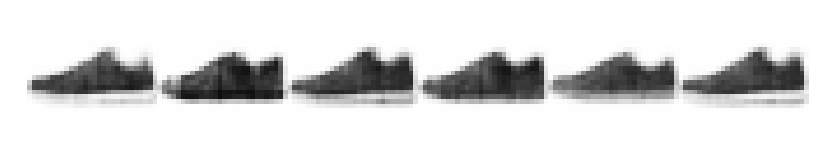

In [190]:
shoes = vsc_conditional_sampling( fashion_images[19]  , vsc_fashion_models_001 )

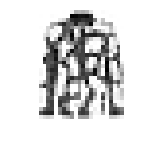

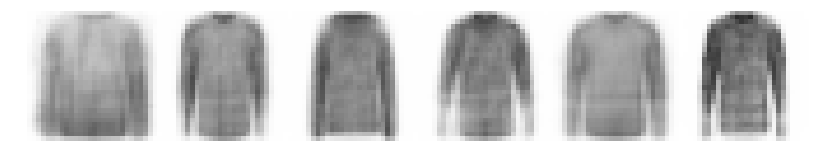

In [417]:
sweaters = vsc_conditional_sampling( fashion_images[2]  , vsc_fashion_models_001 )

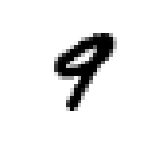

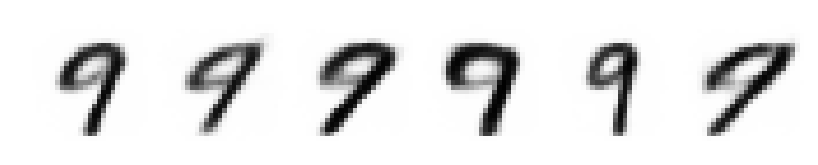

In [348]:
nines= vsc_conditional_sampling( mnist_images[19]  , vsc_mnist_models_001 )

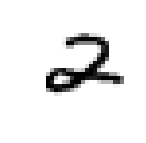

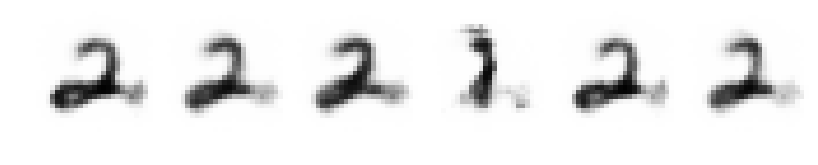

In [350]:
two = vsc_conditional_sampling( mnist_images[10]  , vsc_mnist_models_001 )

### Model VSC - $\alpha$  = 0.5 - 500 epochs

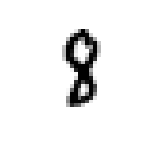

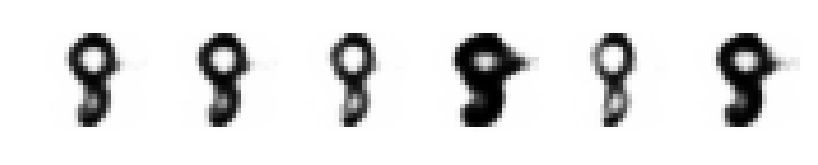

In [222]:
eights = vsc_conditional_sampling( mnist_images[21] , vsc_mnist_models_05 )

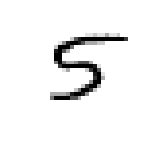

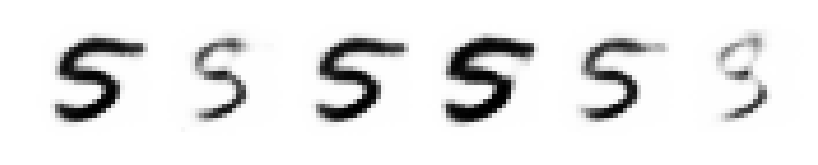

In [305]:
fives = vsc_conditional_sampling( mnist_images[20] , vsc_mnist_models_05 )

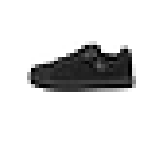

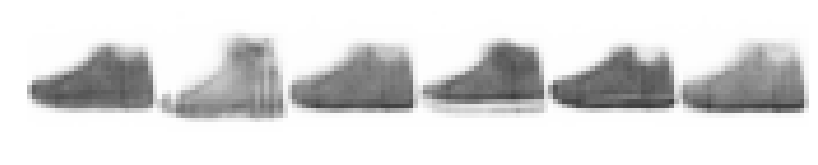

In [271]:
shoes = vsc_conditional_sampling( fashion_images[14] , vsc_fashion_models_05)

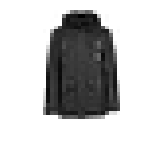

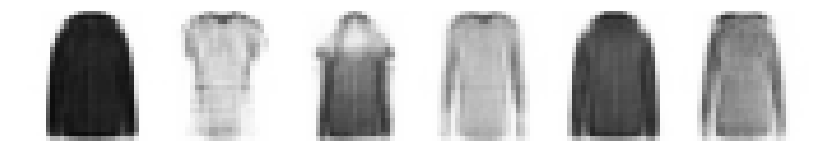

In [198]:
jacket = vsc_conditional_sampling( fashion_images[1] , vsc_fashion_models_05 )

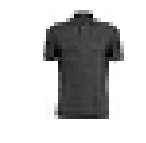

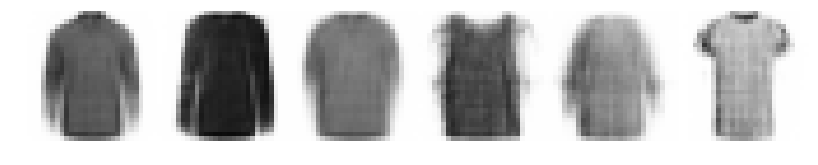

In [292]:
tshirt = vsc_conditional_sampling( fashion_images[22] , vsc_fashion_models_05, percentage = 0.5 )